In [8]:
import torch
from glob import glob
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
import numpy as np
from IPython.display import clear_output
from matplotlib.pyplot import *
import networkx as nx

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
device = torch.device("cpu")

In [20]:
class FastSlowMixture(torch.nn.Module):
    def __init__(self, dimension, rho):
        """
        The Model parameters.
        """
        super().__init__()

        self.l1 = torch.nn.Parameter(torch.empty(1, dimension**2))
        torch.nn.init.kaiming_uniform_(self.l1, a=5**0.5)

        self.flatten = torch.nn.Flatten()

        self.rho = rho

    def forward(self, x, is_cold=True):

        temp = self.rho * (1. - is_cold) + is_cold

        out = self.flatten(x)
        out = torch.nn.functional.linear(out, temp * self.l1)

        return out

In [21]:
def int_to_binary(num, length):
  bin_str = bin(num)[2:]
  
  # Pad the binary string with leading zeros as necessary
  bin_str = '{:0>{}}'.format(bin_str, length)
  
  # Convert the binary string to a binary vector
  return torch.tensor([2*int(digit) - 1. for digit in bin_str])

def probs_from_logits(logits):
   tmp = logits - torch.max(logits)
   probs = torch.exp(tmp)
   probs = probs/torch.sum(probs)
   return probs

def max_cut_loss(log_density, score, reg_value=0.):

    probs = probs_from_logits(log_density)
    log_density = (log_density - torch.max(log_density)).detach()


    loss = - torch.sum(score * probs) 

    ent_reg =  reg_value * torch.sum(log_density * probs) 

    return loss + ent_reg


In [22]:
def vanilla_cut_optimizer(net, opt, iterations, X, y):
    losses_vanilla = []
    out = None
  
    for step in range(iterations):
        net.train()
        opt.zero_grad()

        out = net(X[:,:,None]*X[:,None,:]).squeeze()
        probs = probs_from_logits(out)
        loss = -torch.sum(probs * y)

        if step % 10 == 0:
            print("Step", step, "Cut Score", -loss.item())
        
        loss.backward()
        
        opt.step()
        losses_vanilla.append(-loss.detach())
    return out, losses_vanilla


In [23]:
def hot_cold_cut_optimizer(net, opt, iterations, L, 
                           reg_value, reg_updates, reg_scaling, 
                           mix_prob, X, y):
    losses_regularized = []
    cold_out = None

    new_reg_value = reg_value
    iter_split = np.array_split(np.array(range(iterations)), reg_updates)

    total_iterations = 0
    
    for x in iter_split:
      reg_iterations = len(x)
      new_reg_value = new_reg_value / reg_scaling

      for step in range(reg_iterations):
        net.train()
        opt.zero_grad()

        cold_out = net(X[:,:,None] * X[:,None,:]).squeeze() 
        cold_probs = probs_from_logits(cold_out)
        mean_score = torch.sum(y*cold_probs).item()

        hot_out = net(X[:,:,None] * X[:,None,:], is_cold=False).squeeze() 
        probs_hot = probs_from_logits(hot_out)
        mean_score_hot = torch.sum(probs_hot * y).item()

        if (step + total_iterations) % 10 == 0:
          print("Step", step + total_iterations, "The score of cold samples", mean_score)
          print("Step", step + total_iterations, "The score of hot samples ", mean_score_hot)

        loss = max_cut_loss(cold_out, y, reg_value=new_reg_value)
        loss_hot = max_cut_loss(hot_out, y, reg_value=new_reg_value)

        loss = (1-mix_prob) * loss + mix_prob * loss_hot

        loss.backward()
        
        opt.step()


    
        losses_regularized.append(mean_score)
      total_iterations += reg_iterations 
    return cold_out, losses_regularized


In [24]:
trials = 20
dimension = 15
iterations_vanilla = 1000
iterations_regularized = 1000
step_size = 0.003
find_opt = True
new_reg_value = 2.
reg_updates = 6
reg_scaling = 1.5
mix_prob = 0.2
rho = 0.03

optimal_values = []
vanilla_trajectories = []

vanilla_scores = []
reg_trajectories = []

reg_scores = []
cut_value_list = []

for j in range(trials):
  G = nx.to_numpy_array(
      nx.generators.random_graphs.gnp_random_graph(dimension, 0.5)).astype(int)
      # nx.generators.random_graphs.random_regular_graph(degree, dimension)).astype(int)
  
    
  Gt = torch.tensor(G, dtype=torch.float)

  L = (torch.diag(torch.sum(Gt, axis=1)) - Gt).to(device)
  degree = torch.mean(torch.diag(L))
  print("Avg Degree", degree)

  if find_opt:

    def s(n):
        return np.array( [int(x) for x in bin(2**dimension + n)[2:]][1:] )
    def cut(n):
        return np.sum( G & (s(n)[:,None] < s(n)) )
    def st(n):
        return torch.tensor( [int(x) for x in bin(2**dimension + n)[2:]][1:] ).float()

    X = torch.stack([st(i) for i in range(2**dimension)])
    y = torch.tensor([cut(i) for i in range(2**dimension)]).float()
    opt = torch.max(y)
    print("The value of Max-Cut is:", torch.max(y))

  else:
    y = []
    opt = -1.

  print("Trial:", j)

  cut_value_list.append(y)
  optimal_values.append(opt)

  # Vanilla Cut Optimizer

  net = FastSlowMixture(dimension, 1.)
  # Define Optimizer
  opt = torch.optim.Adam(net.parameters(), lr=step_size)

  out, losses_vanilla = vanilla_cut_optimizer(
      net, opt, iterations=iterations_vanilla, X=X, y=y)

  vanilla_scores.append(out)
  vanilla_trajectories.append(losses_vanilla)
  
  net = FastSlowMixture(dimension, rho)
  opt = torch.optim.Adam(net.parameters(), lr=step_size)


  cold_out, losses_regularized = hot_cold_cut_optimizer(net, 
                                                        opt, 
                                                        iterations=iterations_regularized, 
                                                        L=L,
                                                        reg_value=new_reg_value,
                                                        reg_updates=reg_updates,
                                                        reg_scaling=reg_scaling,
                                                        mix_prob=mix_prob,
                                                        X=X, 
                                                        y=y)

  reg_scores.append(cold_out)
  reg_trajectories.append(losses_regularized)


Avg Degree tensor(6.4000)
The value of Max-Cut is: tensor(34.)
Trial: 0
Step 0 Cut Score 24.013397216796875
Step 10 Cut Score 24.417598724365234
Step 20 Cut Score 24.891416549682617
Step 30 Cut Score 25.621726989746094
Step 40 Cut Score 26.77461814880371
Step 50 Cut Score 28.213788986206055
Step 60 Cut Score 29.656919479370117
Step 70 Cut Score 30.81082534790039
Step 80 Cut Score 31.609655380249023
Step 90 Cut Score 32.09675216674805
Step 100 Cut Score 32.37042236328125
Step 110 Cut Score 32.52657699584961
Step 120 Cut Score 32.62306594848633
Step 130 Cut Score 32.6883544921875
Step 140 Cut Score 32.73603820800781
Step 150 Cut Score 32.772850036621094
Step 160 Cut Score 32.802268981933594
Step 170 Cut Score 32.82625961303711
Step 180 Cut Score 32.84601593017578
Step 190 Cut Score 32.862361907958984
Step 200 Cut Score 32.8759651184082
Step 210 Cut Score 32.88734436035156
Step 220 Cut Score 32.89696502685547
Step 230 Cut Score 32.90517807006836
Step 240 Cut Score 32.91225051879883
Step 2

# Generate Plots

In [27]:
def gen_trajectory_plots(reg_trajectories, vanilla_trajectories):

  for  reg_trajectory, vanilla_trajectory in zip(
      reg_trajectories, vanilla_trajectories):

    figure()
    plot(np.array(reg_trajectory), label='Regularized Fast/Slow Loss')
    plot(np.array(vanilla_trajectory), label='Vanilla Loss')
    legend()
    show()
    

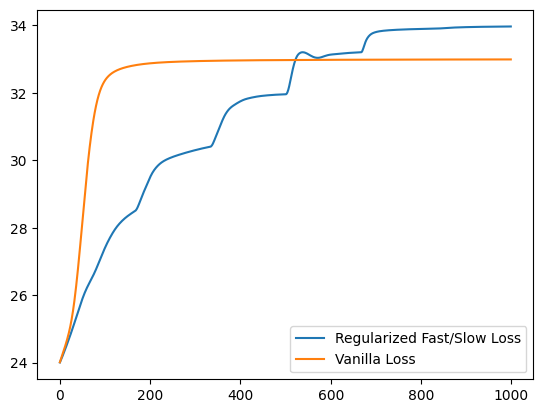

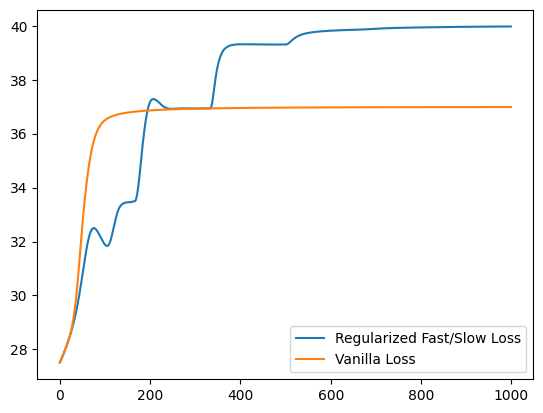

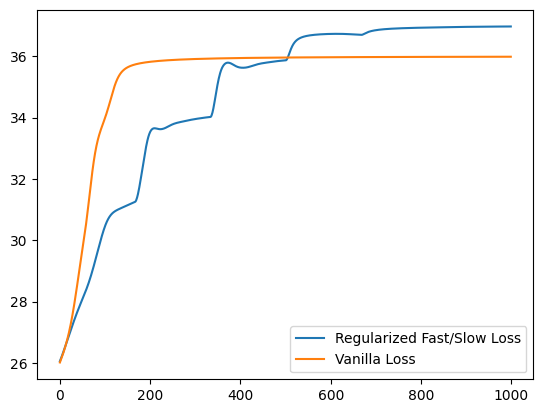

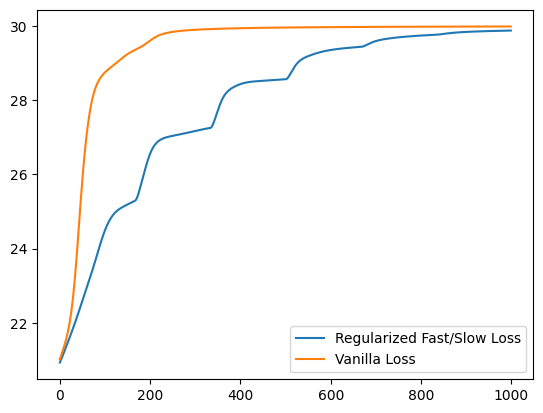

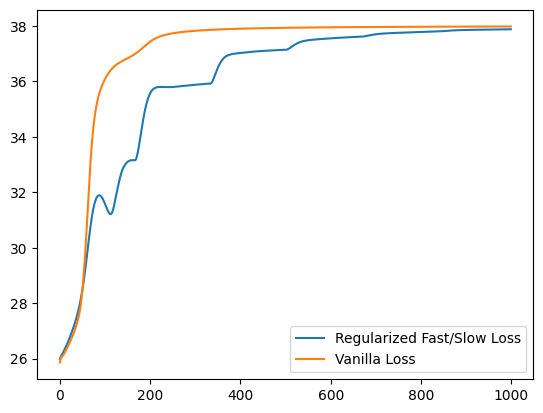

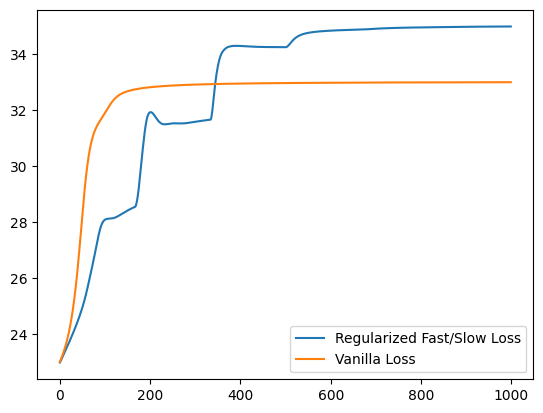

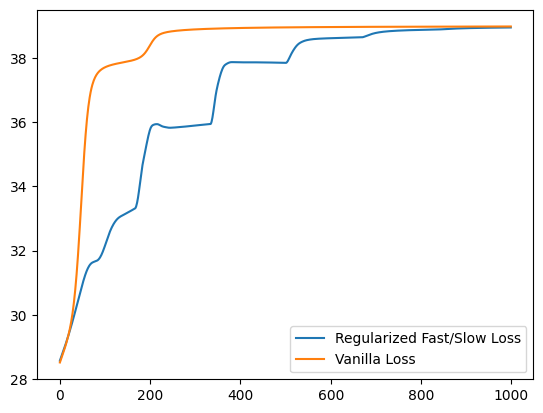

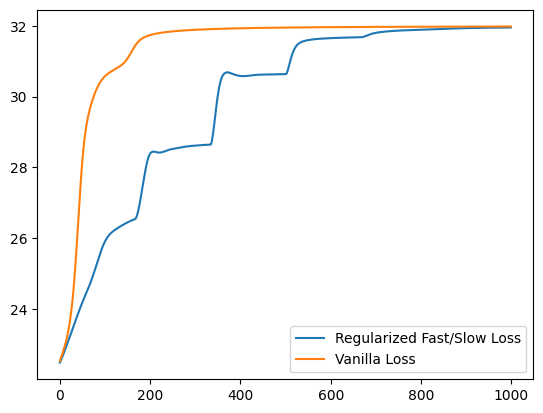

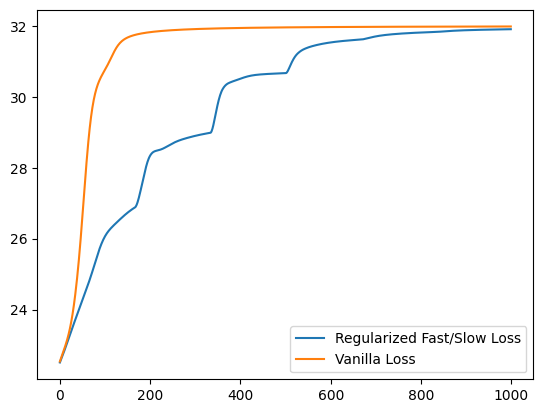

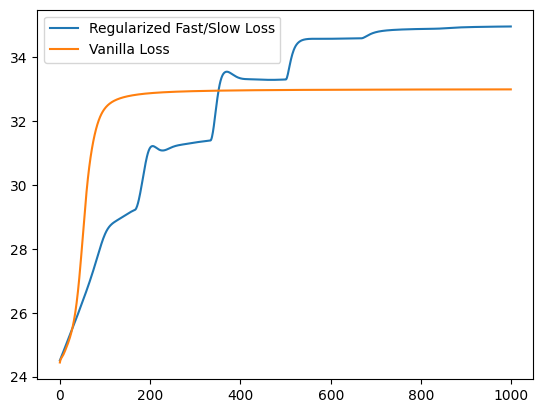

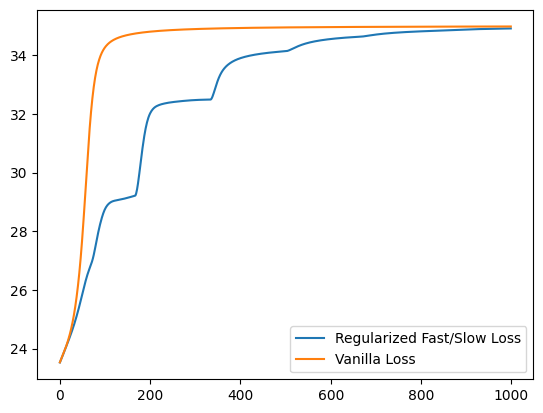

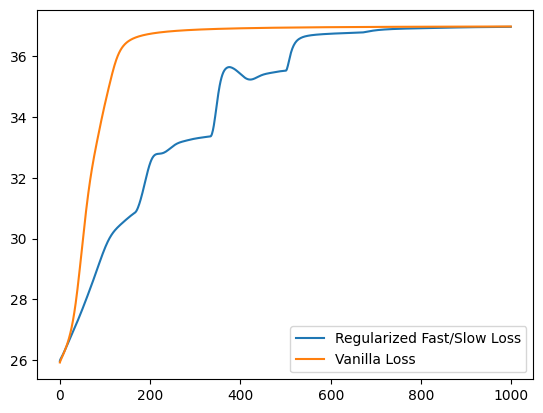

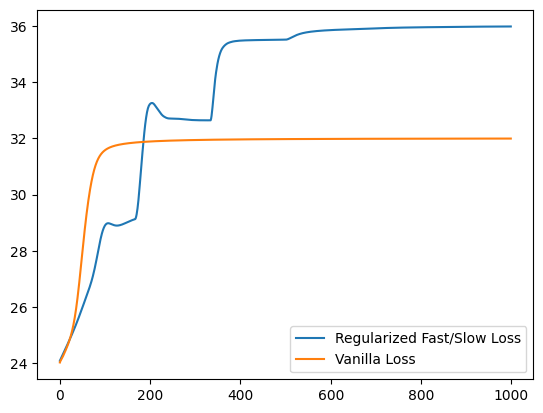

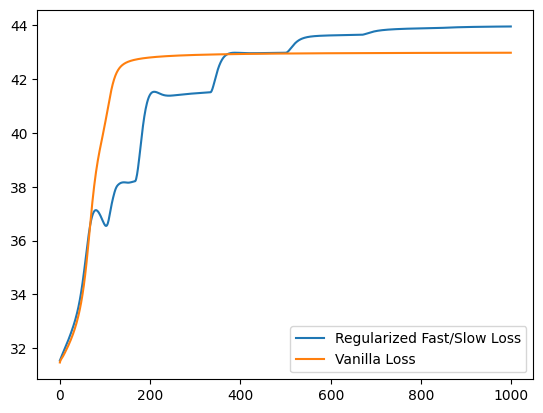

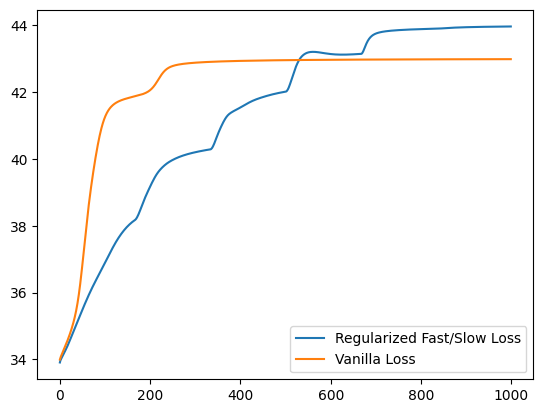

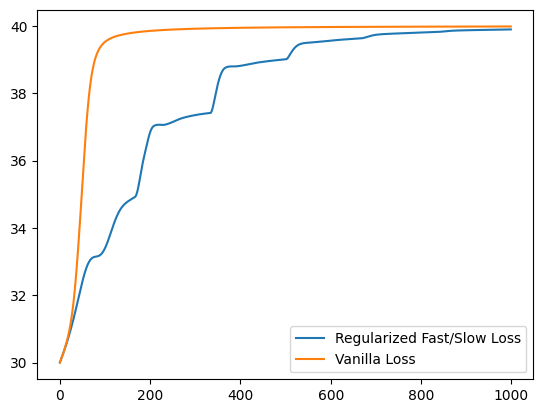

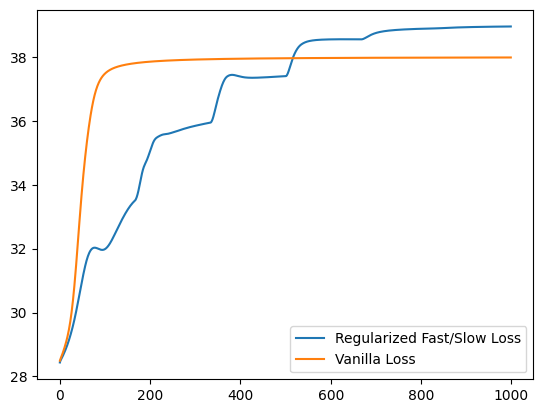

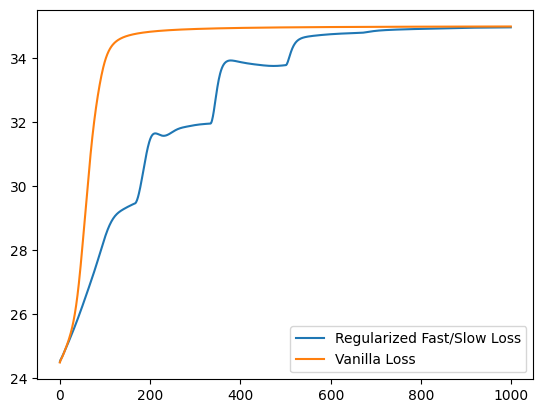

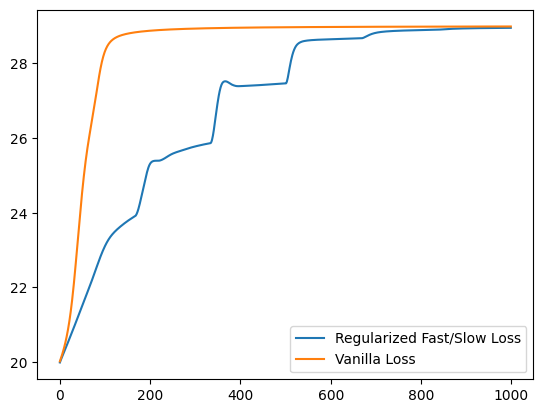

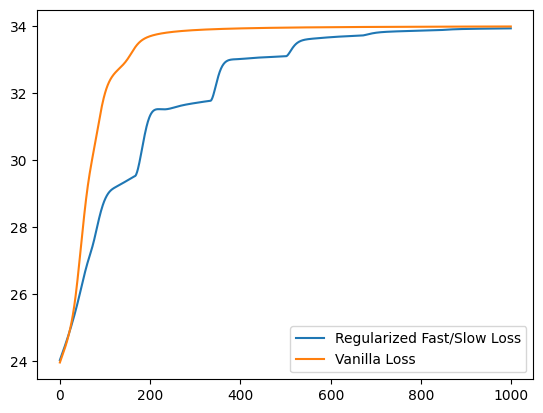

In [28]:
gen_trajectory_plots(reg_trajectories, vanilla_trajectories)

In [113]:
def successful_runs(opt_values, trajectories):
    num = 0
    total = 0
    for opt, trajectory in zip(opt_values, trajectories):
        results = np.array(trajectory)
        best_score = max(results)
        if abs(opt - best_score) < 0.95 :
            num = num + 1
        total = total + 1

    return (total, num)



In [114]:
successful_runs(torch.stack(optimal_values), vanilla_trajectories)

(20, 12)

In [115]:
successful_runs(torch.stack(optimal_values), reg_trajectories)

(20, 20)